In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import json
import pandas
import torch
import torch.nn as nn
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTQConfig
from transformers import BitsAndBytesConfig
# from bitsandbytes.quantizers import BitsAndBytesConfig
# from vllm import LLM

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device : {device}')

# model_name = "beomi/llama-2-ko-7b"
# model_name = "davidkim205/komt-solar-10.7b-sft-v5"
model_name = "davidkim205/nox-solar-10.7b-v4"  # 이게 BEST

tokenizer = AutoTokenizer.from_pretrained(model_name)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
)

## sLLM 기본적인 용어 이해도 질문

In [ ]:
# 기본적인 용어 이해도 확인 질문
question_list = [
    '부동산의 뜻을 설명해줘 ->',
    '대한민국의 수도는? ->',
    '부동산에서 "30평"의 의미를 설명해줘 ->',
    '부동산의 종류는 어떤것들이 있지? ->'
    '아파트와 빌라의 차이점은? ->',
    '아파트와 주택의 차이점은? ->',
    '"부동산 실거래가"라는 용어의 의미를 설명해줘 ->',
    '3000만원, 2000만원, 5000만원이 있을때, 가장 큰 금액은? ->'
]

In [ ]:
result_dict = {
    "model" : model_name,
    "basic_question" : {},
    "test_response" : {}
}

for cnt, q in tqdm(enumerate(question_list)):
    input_ids = tokenizer.encode(q, return_tensors='pt')
    params = {
        "input_ids": input_ids.to(device),
        "max_length": 500,
        "num_return_sequences": 1,
        "temperature": 0.5,
        "pad_token_id": tokenizer.eos_token_id
    }
    output = model.generate(**params)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    result_dict["basic_question"][cnt] = {
        "Q" : q,
        "A" : output_text.split(' ->')[1]
    }


In [1]:
num = 0
print('질문 : ', result_dict['basic_question'][num]['Q'])
print('답변 : ', result_dict['basic_question'][num]['A'])

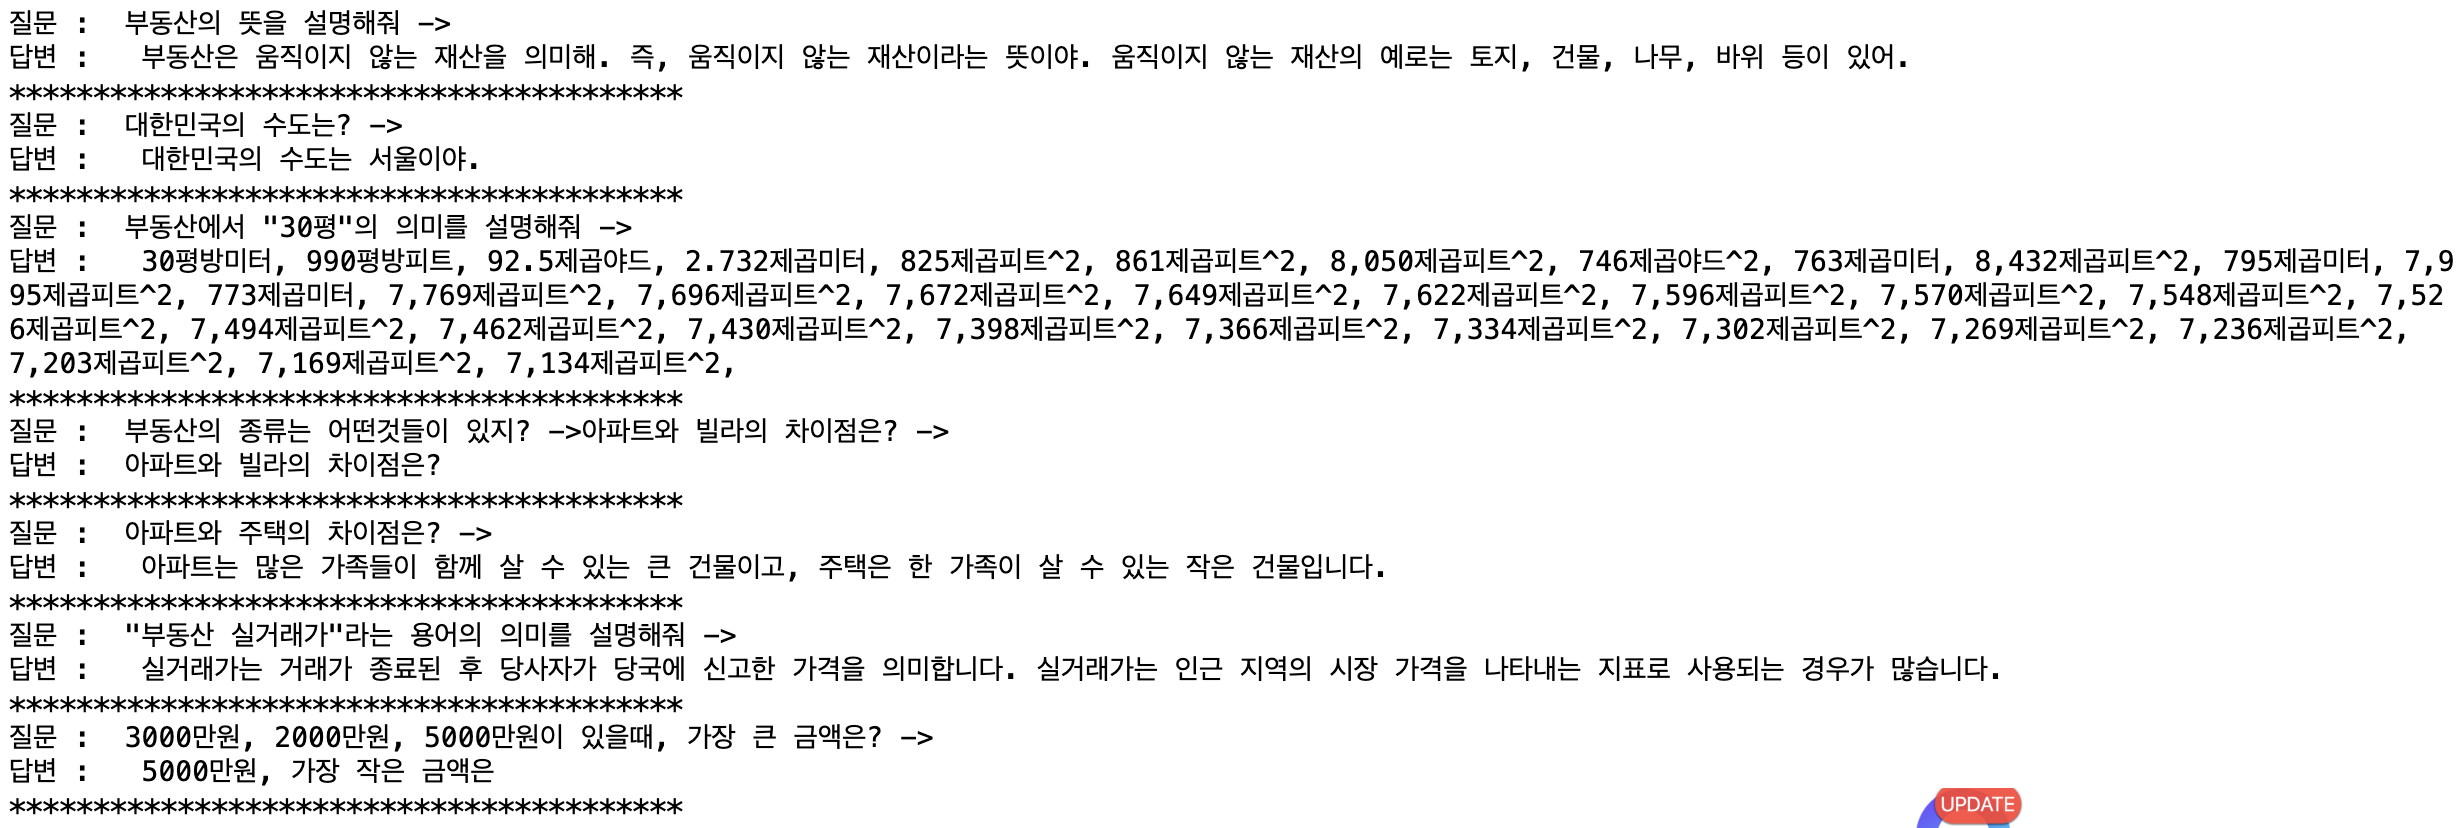

In [2]:
save_path = '/home/jovyan/WIDE_HOME/wontae_kim/temp/data'
file_name = model_name.replace('/', '_') + '.json'

with open(os.path.join(save_path, file_name), 'w') as f:
    json.dump(result_dict, f, indent=2)

## 부동산 실거래 정보가 Prompt로 주어졌을때, 질문과의 조합을 통해 적절한 답변을 생성해 낼 수 있는가?

In [4]:
use_col = [
    '접수연도', 
    '자치구명', 
    '법정동명',
    '지번구분명',
    '건물명', 
    '계약일',
    '물건금액(만원)',
    '건물면적(㎡)',
    '토지면적(㎡)',
    '층',
    '건축년도',
    '건물용도',
    '신고한 개업공인중개사 시군구명',
    '신고구분'
]
data_path = '/home/jovyan/WIDE_HOME/wontae_kim/temp/data'
file_nm = 'seoul_real_estate_2023.csv'
df = pd.read_csv(os.path.join(data_path, file_nm), encoding='CP949', usecols= use_col)
df = df.reset_index()
df

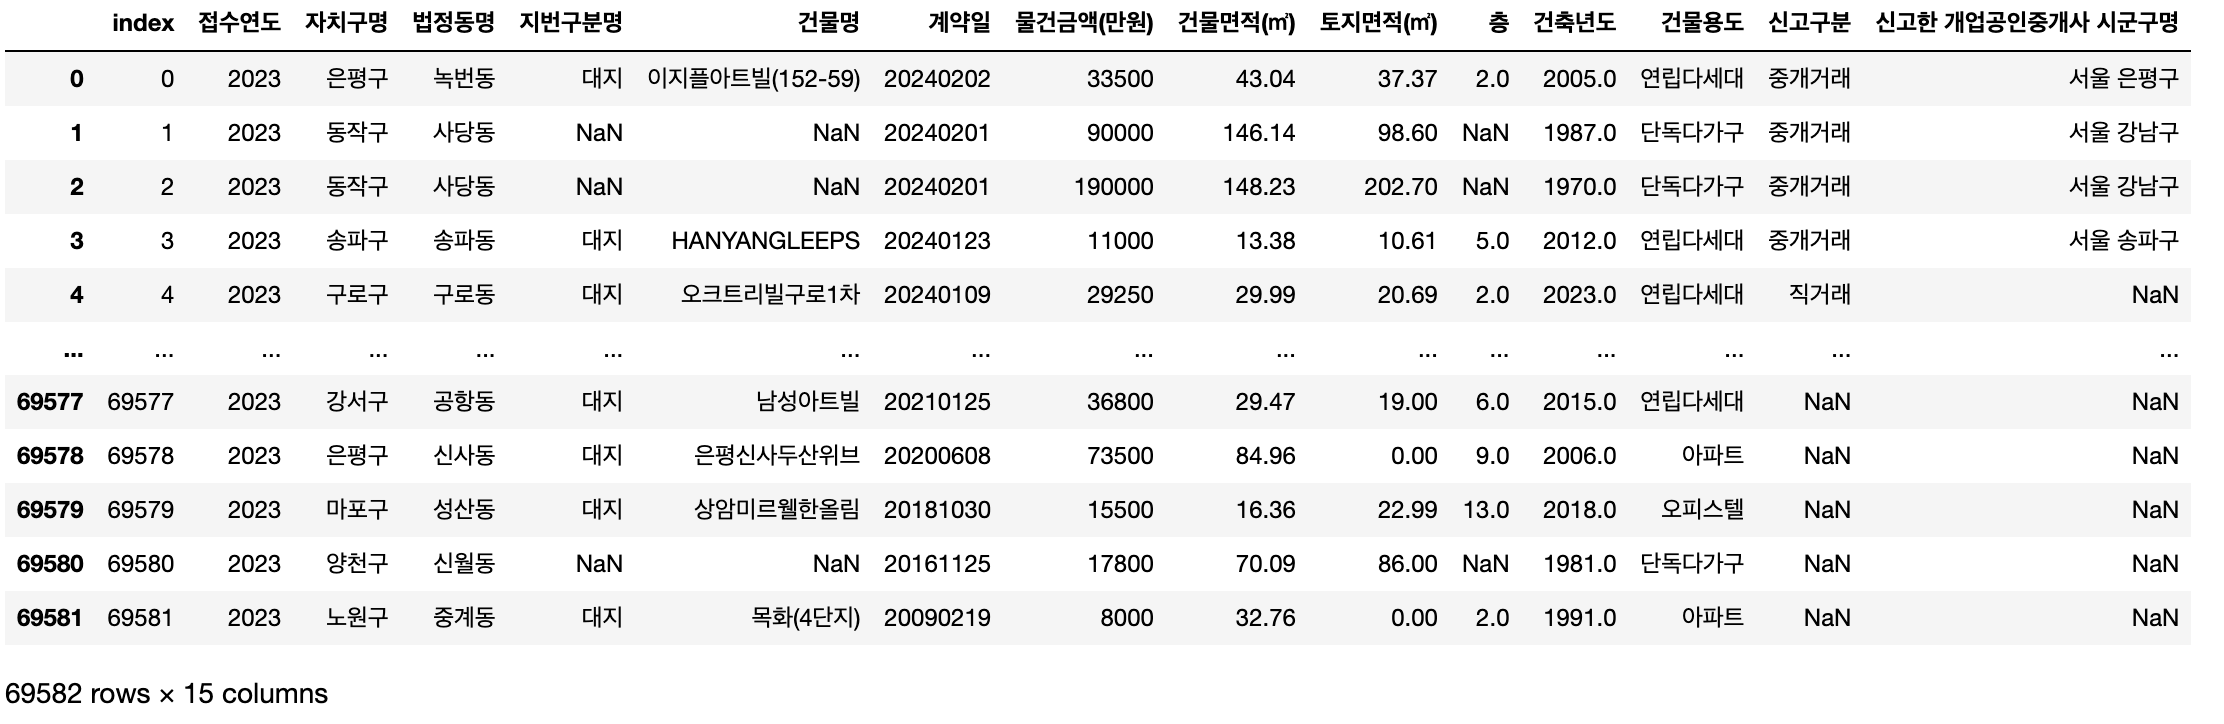

## Preprocessing

In [5]:
# 평수 컬럼 추가
df['면적(평)'] = [int(i) for i in df['건물면적(㎡)']/3.306]

# NaN -> '정보없음' 대체
df['건축년도'] = df['건축년도'].fillna('정보없음')

# # 연식 컬럼 추가
df['사용승인일(연식)'] = ['정보없음' if type(i)==str else int(2024-i) for i in df['건축년도'].values]

#단독다가구의 개념이 모호하며, 데이터수가 많지 않아 제거함
df[df['건물용도']!='단독다가구'] 

# 건물 형태에 대한 검색이 있을 경우, 연립다세대보다는 '빌라'로 검색하는 경우가 많기 때문에 '빌라(연립다세대)'로 변경
df['건물용도'] = ['빌라(연립다세대)' if i =='연립다세대' else i for i in df['건물용도'].values]

# 지번구분명이 대지가 아닌 데이터 제거(총 26건 - 산, 블럭에 해당)
df = df[df['지번구분명']=='대지']

# 일반적인 질의 구문에 포함되지않을 것으로 보이는 정보 컬럼은 제거
del df['접수연도'], df['지번구분명'], df['신고한 개업공인중개사 시군구명']

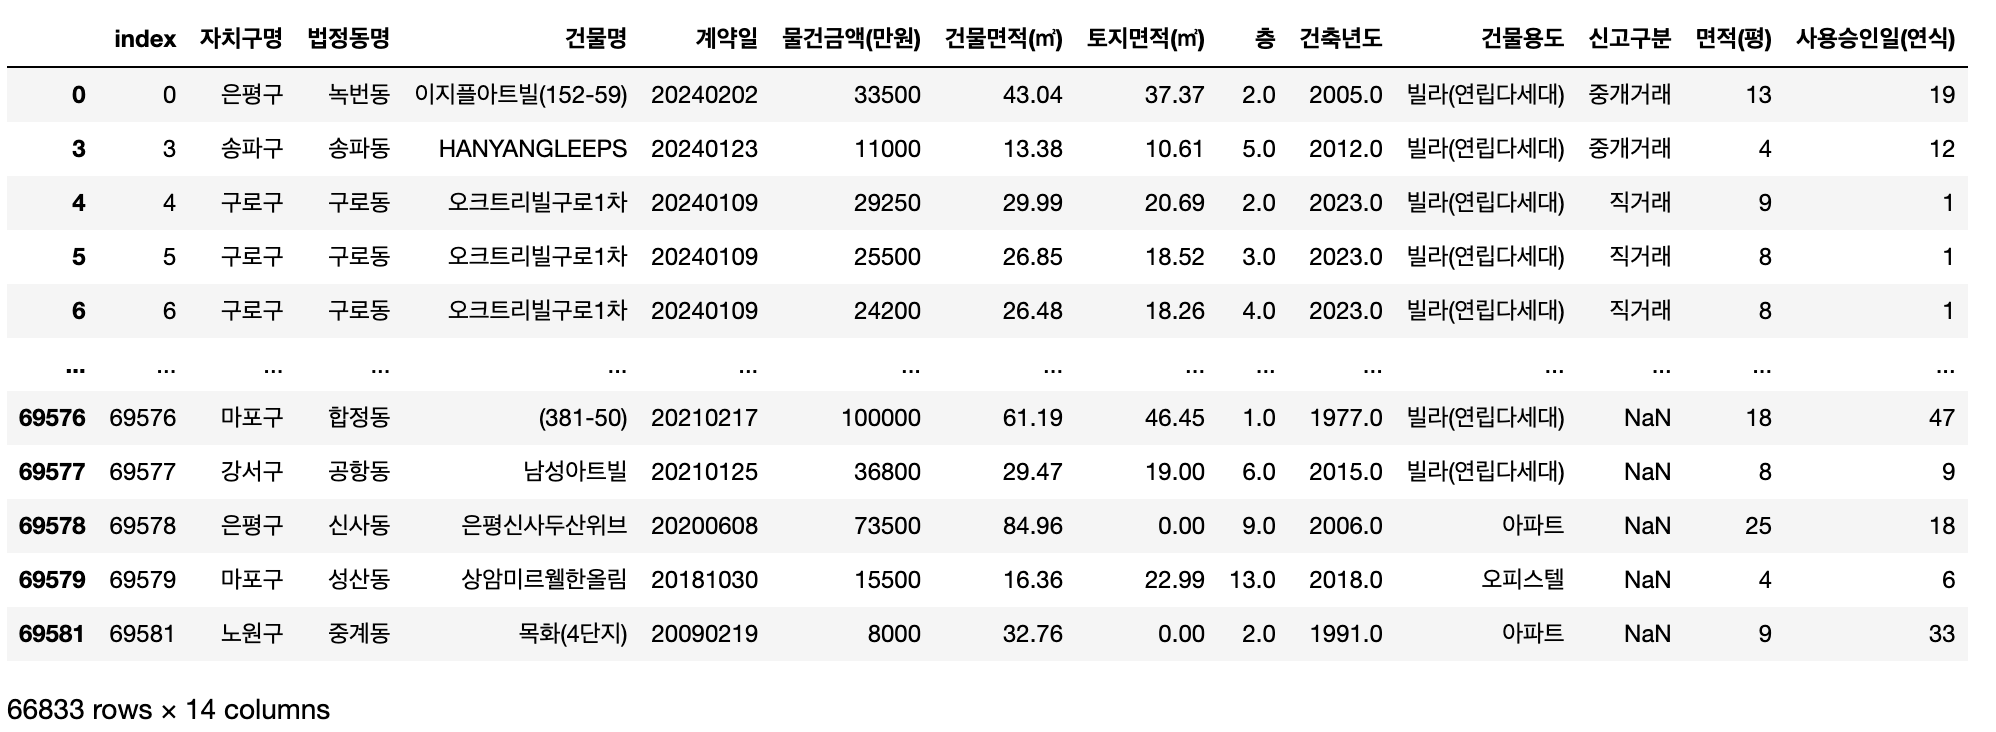

In [6]:
def prompt_generator(question):
    prompt = f"""
    [역할]
    나는 부동산 정보를 참고하여 질문자의 질문에 대한 답변을 출력하는 chatbot 이야.
    질문 내용에 대한 '답변'만 출력해줘
    그리고, 질문에 해당하는 거래가 없을 경우, "말씀주신 내용에 부합하는 부동산 실거래 내역이 없습니다"를 출력해줘

    [질문답변 예시]
    Q.예시질문 : 사당동에서 30평대 아파트중 연식이 30년이내인 실거래를 보여줘

    *******************거래정보*******************
    <거래번호_2>
        - 접수연도 : 2023
        - 자치구명 : 동작구
        - 법정동명 : 사당동
        - 지번구분명 : nan
        - 건물명 : nan
        - 계약일 : 20240201
        - 물건금액(만원) : 190000
        - 건물면적(㎡) : 148.23
        - 면적(평) : 32
        - 토지면적(㎡) : 202.7
        - 층 : nan
        - 건축년도 : 1970.0
        - 건물용도 : 아파트
        - 연식 : 25년
        - 신고구분 : 중개거래
        - 신고한 개업공인중개사 시군구명 : 서울 강남구

    <거래번호_3>
        - 접수연도 : 2023
        - 자치구명 : 강남구
        - 법정동명 : 서초동
        - 지번구분명 : nan
        - 건물명 : nan
        - 계약일 : 20240901
        - 물건금액(만원) : 20000
        - 건물면적(㎡) : 172.23
        - 면적(평) : 62
        - 토지면적(㎡) : 222.7
        - 층 : nan
        - 건축년도 : 1983.2
        - 건물용도 : 아파트
        - 연식 : 20년
        - 신고구분 : 중개거래
        - 신고한 개업공인중개사 시군구명 : 서울 강남구
    
    <거래번호_4>
        - 접수연도 : 2023
        - 자치구명 : 동작구
        - 법정동명 : 사당동
        - 지번구분명 : nan
        - 건물명 : nan
        - 계약일 : 20230101
        - 물건금액(만원) : 20000
        - 건물면적(㎡) : 172.23
        - 면적(평) : 62
        - 토지면적(㎡) : 222.7
        - 층 : nan
        - 건축년도 : 1983.2
        - 건물용도 : 아파트
        - 연식 : 40년
        - 신고구분 : 중개거래
        - 신고한 개업공인중개사 시군구명 : 서울 강남구
    ********************************************
    
    A.예시답변 : 
    사당동에서 30평대 아파트중 연식이 30년이내인 실거래 내역은 아래와 같습니다.

    <거래번호_2>
        - 접수연도 : 2023
        - 자치구명 : 동작구
        - 법정동명 : 사당동
        - 지번구분명 : nan
        - 건물명 : nan
        - 계약일 : 20240201
        - 물건금액(만원) : 190000
        - 건물면적(㎡) : 148.23
        - 면적(평) : 32
        - 토지면적(㎡) : 202.7
        - 층 : nan
        - 건축년도 : 1970.0
        - 건물용도 : 단독다가구
        - 연식 : 25년
        - 신고구분 : 중개거래
        - 신고한 개업공인중개사 시군구명 : 서울 강남구

    =================================================================
    
    -> 아래의 거래정보를 참고하여 질문에 답변해줘

    Q.질문 : {question}

    *******************거래정보*******************
    """
    start_num = 515
    for cnt in range(15):
        for num, (col, val) in enumerate(df.iloc[start_num+cnt, :].items()):
            if num==0:
                prompt += f'<거래번호_{val}>\n'
            else :
                prompt += f'    - {col} : {val}\n'
        prompt+='\n'
    add_text = f"""
    ********************************************
    """
    prompt+=add_text
    return prompt

In [7]:
question_list = [
    '구로구의 20평대 빌라 관련 거래들을 보여줘',
    '최근 강남의 오피스텔 2억원대 실거래들을 보여줘 ',
    '건물면적이 50이상인 거래들을 보여줘',
    '구로구에서 거래된 20평대 아파트 거래내역을 보여줘',
    '최근 구로동의 부동산 거래는 몇건이지?'
]
input_list = [prompt_generator(q) for q in question_list]
print(input_list[0])